In [334]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.graphics.tsaplots import plot_acf
import  matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib


In [335]:
df = pd.read_csv("../BTC_1_year_data.csv").set_index("close_time")
df

,open,high,low,close,volume
close_time,,,,,
2024-11-30 15:29:59.999000+00:00,96602.51,96659.50,96532.00,96659.50,133.45453
2024-11-30 15:44:59.999000+00:00,96659.49,96691.69,96602.01,96634.28,117.43398
2024-11-30 15:59:59.999000+00:00,96634.28,96732.15,96602.67,96645.41,85.14427
2024-11-30 16:14:59.999000+00:00,96645.42,96757.06,96615.52,96652.01,106.03529
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001
...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655


#### Feature Engineering

In [336]:
df["close_log_return"] = np.log(df["close"]/df["close"].shift())

    Create lagged features

In [337]:
df = df.copy()

In [338]:
def generate_ma_features(df, close_col="close", windows=[5, 10], shift_pct=True):
    """
    Generate moving average and pct-change-to-close features for a list of window sizes.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with at least a 'close' column.
    close_col : str
        Column name for the close price.
    windows : list
        List of integers for rolling windows.
    shift_pct : bool
        Whether to shift pct-change features by 1 step to avoid leakage.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with new features added.
    """
    df = df.copy()

    for w in windows:
        ma_col = f"{w}ma"
        pct_col = f"pct_change_{w}ma_close"

        # Moving average
        df[ma_col] = df[close_col].rolling(w).mean()

        # Percentage difference from MA
        df[pct_col] = (df[close_col] - df[ma_col]) / df[ma_col] * 100

        # Shift to avoid leakage (optional)
        if shift_pct:
            df[pct_col] = df[pct_col].shift()

    return df


windows = [10, 50,200]

df = generate_ma_features(df, windows=windows)


In [339]:
df["close_log_return_lag_1"] = df["close_log_return"].shift()
df["close_log_return_lag_2"] = df["close_log_return"].shift(2)
df["close_log_return_lag_3"] = df["close_log_return"].shift(3)

In [340]:
df = df.dropna(how="any")
# df= df.drop(columns=["open", "high", "low", "close", "volume"])

    Create binary classification target
        - 1=> Long => Price moves up
        - 0=> Short => Price goes down

In [341]:
df["close_log_return_dir"] = df["close_log_return"].map(lambda x:1 if x>0 else 0)
# df = df.drop(columns="close_log_return")

In [342]:
df

,open,high,low,close,volume,close_log_return,10ma,pct_change_10ma_close,50ma,pct_change_50ma_close,200ma,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
close_time,,,,,,,,,,,,,,,,
2024-12-02 17:29:59.999000+00:00,96263.99,96324.00,95372.72,95372.73,697.37610,-0.009302,96538.085,-0.381805,95839.3012,0.415145,96638.00240,-0.393656,0.001003,-0.002374,-0.002114,0
2024-12-02 17:44:59.999000+00:00,95372.73,95498.87,95051.11,95450.00,1061.30282,0.000810,96439.485,-1.207145,95810.6534,-0.486827,96632.08100,-1.309291,-0.009302,0.001003,-0.002374,1
2024-12-02 17:59:59.999000+00:00,95450.00,95460.00,94395.00,94604.03,954.78259,-0.008902,96232.862,-1.026016,95768.7340,-0.376423,96621.87410,-1.223280,0.000810,-0.009302,0.001003,0
2024-12-02 18:14:59.999000+00:00,94604.03,95396.00,94488.00,95367.99,846.79767,0.008043,96053.661,-1.692594,95745.1934,-1.216163,96615.45400,-2.088393,-0.008902,0.000810,-0.009302,1
2024-12-02 18:29:59.999000+00:00,95368.00,95599.00,95235.99,95515.42,315.32601,0.001545,95900.403,-0.713842,95728.3020,-0.393966,96610.25400,-1.291164,0.008043,-0.008902,0.000810,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016,-0.000951,91492.959,0.362326,91108.4782,0.741975,90973.87660,0.876005,0.000886,-0.001771,0.004175,0
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310,-0.001403,91543.501,0.207416,91121.2960,0.630295,90973.85595,0.779183,-0.000951,0.000886,-0.001771,0
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655,-0.002124,91555.036,0.011687,91129.5986,0.475085,90973.25385,0.637924,-0.001403,-0.000951,0.000886,0


    Check class imbalance

In [343]:
print(df["close_log_return_dir"].value_counts())

close_log_return_dir
0    17459
1    17381
Name: count, dtype: int64


#### Split data into training and testing set but in temporal order

In [344]:
def time_split(x, train_size = 0.75):
    i = int(len(x)*train_size)
    return x[:i].copy(), x[i:].copy()

df_train, df_test = time_split(df, train_size=0.7)

In [345]:
df_train

,open,high,low,close,volume,close_log_return,10ma,pct_change_10ma_close,50ma,pct_change_50ma_close,200ma,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
close_time,,,,,,,,,,,,,,,,
2024-12-02 17:29:59.999000+00:00,96263.99,96324.00,95372.72,95372.73,697.37610,-0.009302,96538.085,-0.381805,95839.3012,0.415145,96638.00240,-0.393656,0.001003,-0.002374,-0.002114,0
2024-12-02 17:44:59.999000+00:00,95372.73,95498.87,95051.11,95450.00,1061.30282,0.000810,96439.485,-1.207145,95810.6534,-0.486827,96632.08100,-1.309291,-0.009302,0.001003,-0.002374,1
2024-12-02 17:59:59.999000+00:00,95450.00,95460.00,94395.00,94604.03,954.78259,-0.008902,96232.862,-1.026016,95768.7340,-0.376423,96621.87410,-1.223280,0.000810,-0.009302,0.001003,0
2024-12-02 18:14:59.999000+00:00,94604.03,95396.00,94488.00,95367.99,846.79767,0.008043,96053.661,-1.692594,95745.1934,-1.216163,96615.45400,-2.088393,-0.008902,0.000810,-0.009302,1
2024-12-02 18:29:59.999000+00:00,95368.00,95599.00,95235.99,95515.42,315.32601,0.001545,95900.403,-0.713842,95728.3020,-0.393966,96610.25400,-1.291164,0.008043,-0.008902,0.000810,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-13 17:14:59.999000+00:00,121421.77,121699.99,121421.76,121603.46,221.47361,0.001495,121209.353,0.171427,120357.9142,0.920862,119551.99585,1.570796,0.000775,-0.001733,0.000243,1
2025-08-13 17:29:59.999000+00:00,121603.46,121850.31,121585.21,121792.00,229.89855,0.001549,121299.480,0.325146,120407.0540,1.034868,119560.44580,1.715960,0.001495,0.000775,-0.001733,1
2025-08-13 17:44:59.999000+00:00,121792.00,121829.67,121560.00,121604.17,289.32526,-0.001543,121362.025,0.406036,120451.4174,1.150220,119566.55475,1.866465,0.001549,0.001495,0.000775,0


In [346]:
df_test

,open,high,low,close,volume,close_log_return,10ma,pct_change_10ma_close,50ma,pct_change_50ma_close,200ma,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
close_time,,,,,,,,,,,,,,,,
2025-08-13 18:29:59.999000+00:00,121908.98,121935.01,121583.31,121627.74,235.53895,-0.002310,121615.586,0.299557,120601.6024,1.126921,119585.59755,1.947455,0.000703,0.001800,-0.001543,0
2025-08-13 18:44:59.999000+00:00,121627.73,121877.31,121429.36,121504.73,341.09368,-0.001012,121615.195,0.009994,120646.8972,0.850849,119593.35120,1.707683,-0.002310,0.000703,0.001800,0
2025-08-13 18:59:59.999000+00:00,121504.72,121711.69,121460.67,121639.20,143.38126,0.001106,121625.300,-0.090832,120696.3724,0.711028,119601.77895,1.598232,-0.001012,-0.002310,0.000703,1
2025-08-13 19:14:59.999000+00:00,121639.19,122000.00,121524.27,121934.01,270.48510,0.002421,121685.929,0.011429,120751.4526,0.781157,119611.91350,1.703504,0.001106,-0.001012,-0.002310,1
2025-08-13 19:29:59.999000+00:00,121934.00,122547.54,121932.00,122358.00,725.88234,0.003471,121779.552,0.203870,120810.4124,0.979332,119624.72460,1.941359,0.002421,0.001106,-0.001012,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016,-0.000951,91492.959,0.362326,91108.4782,0.741975,90973.87660,0.876005,0.000886,-0.001771,0.004175,0
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310,-0.001403,91543.501,0.207416,91121.2960,0.630295,90973.85595,0.779183,-0.000951,0.000886,-0.001771,0
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655,-0.002124,91555.036,0.011687,91129.5986,0.475085,90973.25385,0.637924,-0.001403,-0.000951,0.000886,0


In [347]:
print(df_train["close_log_return_dir"].value_counts())
print(df_test["close_log_return_dir"].value_counts())

close_log_return_dir
0    12232
1    12156
Name: count, dtype: int64
close_log_return_dir
0    5227
1    5225
Name: count, dtype: int64


### Scikit-learn Logistic Regression

### Research

In [348]:
btcusdt_train = df_train.copy()
btcusdt_test = df_test.copy()

In [349]:
btcusdt_test

,open,high,low,close,volume,close_log_return,10ma,pct_change_10ma_close,50ma,pct_change_50ma_close,200ma,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
close_time,,,,,,,,,,,,,,,,
2025-08-13 18:29:59.999000+00:00,121908.98,121935.01,121583.31,121627.74,235.53895,-0.002310,121615.586,0.299557,120601.6024,1.126921,119585.59755,1.947455,0.000703,0.001800,-0.001543,0
2025-08-13 18:44:59.999000+00:00,121627.73,121877.31,121429.36,121504.73,341.09368,-0.001012,121615.195,0.009994,120646.8972,0.850849,119593.35120,1.707683,-0.002310,0.000703,0.001800,0
2025-08-13 18:59:59.999000+00:00,121504.72,121711.69,121460.67,121639.20,143.38126,0.001106,121625.300,-0.090832,120696.3724,0.711028,119601.77895,1.598232,-0.001012,-0.002310,0.000703,1
2025-08-13 19:14:59.999000+00:00,121639.19,122000.00,121524.27,121934.01,270.48510,0.002421,121685.929,0.011429,120751.4526,0.781157,119611.91350,1.703504,0.001106,-0.001012,-0.002310,1
2025-08-13 19:29:59.999000+00:00,121934.00,122547.54,121932.00,122358.00,725.88234,0.003471,121779.552,0.203870,120810.4124,0.979332,119624.72460,1.941359,0.002421,0.001106,-0.001012,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016,-0.000951,91492.959,0.362326,91108.4782,0.741975,90973.87660,0.876005,0.000886,-0.001771,0.004175,0
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310,-0.001403,91543.501,0.207416,91121.2960,0.630295,90973.85595,0.779183,-0.000951,0.000886,-0.001771,0
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655,-0.002124,91555.036,0.011687,91129.5986,0.475085,90973.25385,0.637924,-0.001403,-0.000951,0.000886,0


In [350]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import os
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------
# 0. REPRODUCIBILITY SETTINGS
# -------------------------------------------------------
SEED = 99
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -------------------------------------------------------
# 1. STANDARDIZE FEATURES AND CREATE TENSORS
# -------------------------------------------------------

features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3', 'pct_change_50ma_close','pct_change_10ma_close','pct_change_200ma_close']
target = 'close_log_return_dir'

# Fit scaler on training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(btcusdt_train[features].values)
X_test_scaled  = scaler.transform(btcusdt_test[features].values)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train = torch.tensor(btcusdt_train[target].values, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(btcusdt_test[target].values, dtype=torch.float32).unsqueeze(1)

# -------------------------------------------------------
# 2. DEFINE MODEL (Logistic Regression)
# -------------------------------------------------------

no_features = len(features)

class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

model = LogisticRegression(no_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# -------------------------------------------------------
# 3. TRAINING LOOP (FULL-BATCH GRADIENT DESCENT)
# -------------------------------------------------------
for epoch in range(20000):
    optimizer.zero_grad()
    y_pred_logits = model(X_train)
    loss = criterion(y_pred_logits, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print("Epoch:", epoch, "Loss:", loss.item())

# -------------------------------------------------------
# 4. CHECK TRAINED PARAMETERS
# -------------------------------------------------------
print("\nFinal weight:", model.linear.weight.data)
print("Final bias:", model.linear.bias.data)

# -------------------------------------------------------
# 5. EVALUATION ON TEST SET
# -------------------------------------------------------
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred_proba = torch.sigmoid(y_pred_logits)
    y_pred_binary = (y_pred_proba >= 0.5).float()

y_test_np = y_test.squeeze().numpy()
y_pred_binary_np = y_pred_binary.squeeze().numpy()
y_pred_proba_np = y_pred_proba.squeeze().numpy()

# Metrics
accuracy = np.mean(y_pred_binary_np == y_test_np)
buy_signals = np.sum(y_pred_binary_np == 1)

print("\n--- Model Evaluation ---")
print(f"Total Test Samples (T): {len(X_test)}")
print(f"Number of Buy Signals (Predicted UP): {int(buy_signals)}")
print(f"Directional Accuracy (DA): {accuracy:.4f}")

# Optional: confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_np, y_pred_binary_np)
print("\nConfusion Matrix:\n", cm)


Epoch: 0 Loss: 0.8021477460861206
Epoch: 500 Loss: 0.7759196162223816
Epoch: 1000 Loss: 0.7558854818344116
Epoch: 1500 Loss: 0.7407991886138916
Epoch: 2000 Loss: 0.729515016078949
Epoch: 2500 Loss: 0.7210733890533447
Epoch: 3000 Loss: 0.7147243618965149
Epoch: 3500 Loss: 0.7099092602729797
Epoch: 4000 Loss: 0.7062233686447144
Epoch: 4500 Loss: 0.7033769488334656
Epoch: 5000 Loss: 0.7011623382568359
Epoch: 5500 Loss: 0.6994292140007019
Epoch: 6000 Loss: 0.698066771030426
Epoch: 6500 Loss: 0.6969922780990601
Epoch: 7000 Loss: 0.696142852306366
Epoch: 7500 Loss: 0.6954697966575623
Epoch: 8000 Loss: 0.6949353218078613
Epoch: 8500 Loss: 0.6945100426673889
Epoch: 9000 Loss: 0.6941705346107483
Epoch: 9500 Loss: 0.6938987374305725
Epoch: 10000 Loss: 0.6936801075935364
Epoch: 10500 Loss: 0.6935033798217773
Epoch: 11000 Loss: 0.6933595538139343
Epoch: 11500 Loss: 0.6932416558265686
Epoch: 12000 Loss: 0.6931443214416504
Epoch: 12500 Loss: 0.6930631995201111
Epoch: 13000 Loss: 0.6929948329925537
E

In [351]:
confusion_matrix(y_test_np, y_pred_binary_np)

array([[2960, 2267],
       [2712, 2513]])

<p style="color: yellow">TP, FP, TN, FN are purely relative to whatever you declare as the positive class.</p>

    - 1 is UP prediction
    - 0 is DOWN prediction
    - 1 is positive class
    - 0 is negative class



In [352]:
TN = cm[0][0]   #True Down  - When it should be down and model predicted down
FN = cm[1][0]   #False down - When it should be up but the model predicted down
FP = cm[0][1]   #False up   - When it should be down but the model predicted up
TP = cm[1][1]   #True UP    - When it should be up and the model predicted up

#### Evaluate win rate

    Accuracy Measure

In [353]:
(TP+TN)/(TP+TN+FP+FN) 

np.float64(0.5236318407960199)

#### Evaluate the up Predictibility

In [354]:
TP/(TP+FP)

np.float64(0.5257322175732217)

#### Evaluate the up Predictibility

<p style="color: yellow; font-size: 20px">Recall</p>
    


In [355]:
TP/(TP+FN)  # Here we are essentially looking at - from all the True classes, how many True classes I predicted correctly

np.float64(0.4809569377990431)

<p style="color: yellow; font-size: 20px">Precision</p>

Precision is, for all of my predictions for a particular class, how many times I was right


In [356]:
TP/(TP+FP) # From all the times I predicted True/UP, How many were actually true/up

np.float64(0.5257322175732217)

#### Evaluate down predictability

<p style="color: yellow; font-size: 20px">Recall</p>


In [357]:
TN / (TN+FP) # Here we are essentially looking at - from all the False classes, how many false classes I predicted correctly

np.float64(0.5662904151520949)

In [358]:
TN / (TN+FN)    # From as many times I predicted false, how many were actually false.

np.float64(0.5218617771509168)

###### **PRECISION**
###### "When I predict UP, how often am I actually right?"

```python
Precision = TP / (TP + FP)
```

**Out of all my UP predictions, how many were actually correct?**

- **Focus:** My predicted UP events (my actions)
- **Fear:** False Positives (wrongly predicting UP when it's actually DOWN)
- **High precision = When I say UP, you can trust me — but I might be missing opportunities**

---

###### **RECALL**
###### "How many actual UP moves did I successfully catch?"

```python
Recall = TP / (TP + FN)
```

**Out of all the real UP days, how many did my model correctly predict as UP?**

- **Focus:** The actual UP events (reality)
- **Fear:** False Negatives (missing UP days)
- **High recall = I catch most of the UP moves, even if I sometimes make wrong predictions**

---

###### **The Key Difference**

| | Precision | Recall |
|---|-----------|--------|
| **Perspective** | YOUR predictions | REALITY's events |
| **Denominator** | What YOU predicted | What ACTUALLY happened |
| **Question** | "Am I accurate?" | "Am I thorough?" |
| **Trading analogy** | "Hit rate of my signals" | "% of opportunities captured" |

---

###### **Trading Strategy Examples**

###### **High Precision, Low Recall Strategy**
- Very selective, only trades slam-dunk setups
- Few trades, but most are winners
- Good for: High transaction costs, limited capital, risk-averse

###### **Low Precision, High Recall Strategy**
- Casts a wide net, takes many signals
- Catches most moves, but many false alarms
- Good for: Low transaction costs, diversification, systematic execution

###### **Balanced Strategy**
- Optimizes F1-score (harmonic mean of precision and recall)
- Trades off some accuracy for better coverage
- Good for: Most real-world trading applications

---

###### **The Trade-off**

You can't maximize both simultaneously:

- ↑ Threshold → ↑ Precision, ↓ Recall (be picky)
- ↓ Threshold → ↓ Precision, ↑ Recall (be aggressive)

**The optimal balance depends on your strategy's economics.**


#### Directional Balance : Short Ratio

In [359]:
short_ratio = (FN+TN)/(FN+TN+FP+FP)
short_ratio

np.float64(0.5557515187144817)

#### Directional Balance: Long Ratio

In [360]:
long_ratio = (FP+TP)/(FN+TN+FP+FP)
long_ratio

np.float64(0.4683519498334313)

#### Directional Imbalance

In [361]:
short_ratio/long_ratio

np.float64(1.1866108786610878)

#### Evaluate Reciever Owner Characteristic (ROC curve)

In [362]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [363]:
auc = roc_auc_score(y_test,y_pred_binary_np)
auc

0.523623676475569

    If auc is less than 0.5, it is below than random guessing
    If auc is 0.5, it is random
    If auc is greater than 0.5, it has a predictive power and a statistical edge
    If auc is 1.0 - Perfect discriminate ability

In [364]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary_np)

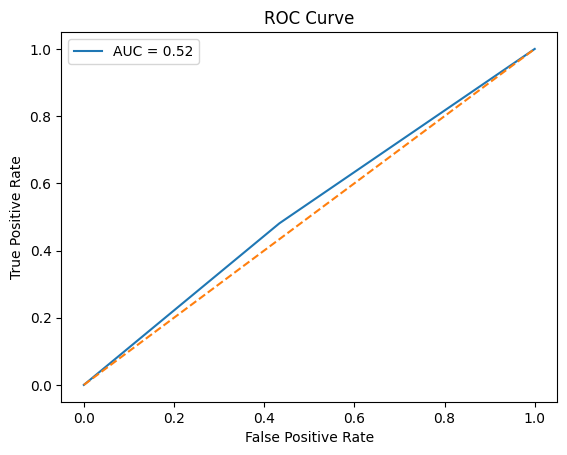

In [365]:
plt.figure()
plt.plot(fpr,tpr, label={f"AUC = {auc:.2f}"})
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#### Evaluating model's profitability (Out-of-sample)

In [366]:
df_test["y_pred_binary"] = y_pred_binary_np
df_test["y_pred_prob"]= y_pred_proba_np

In [367]:
df_test[["close_log_return","y_pred_binary", "y_pred_prob"]]

,close_log_return,y_pred_binary,y_pred_prob
close_time,,,
2025-08-13 18:29:59.999000+00:00,-0.002310,0.0,0.476537
2025-08-13 18:44:59.999000+00:00,-0.001012,1.0,0.501076
2025-08-13 18:59:59.999000+00:00,0.001106,1.0,0.505693
2025-08-13 19:14:59.999000+00:00,0.002421,0.0,0.493907
2025-08-13 19:29:59.999000+00:00,0.003471,0.0,0.486802
...,...,...,...
2025-11-30 14:14:59.999000+00:00,-0.000951,0.0,0.486313
2025-11-30 14:29:59.999000+00:00,-0.001403,0.0,0.479471
2025-11-30 14:44:59.999000+00:00,-0.002124,1.0,0.500049


#### Add Directional signal

In [368]:
df_test["dir_signal"] =  np.where(df_test["y_pred_binary"]==1,1,-1) # We have just replaced the zeroes with -1
df_test[["close_log_return","y_pred_binary", "y_pred_prob","dir_signal"]]

,close_log_return,y_pred_binary,y_pred_prob,dir_signal
close_time,,,,
2025-08-13 18:29:59.999000+00:00,-0.002310,0.0,0.476537,-1
2025-08-13 18:44:59.999000+00:00,-0.001012,1.0,0.501076,1
2025-08-13 18:59:59.999000+00:00,0.001106,1.0,0.505693,1
2025-08-13 19:14:59.999000+00:00,0.002421,0.0,0.493907,-1
2025-08-13 19:29:59.999000+00:00,0.003471,0.0,0.486802,-1
...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,-0.000951,0.0,0.486313,-1
2025-11-30 14:29:59.999000+00:00,-0.001403,0.0,0.479471,-1
2025-11-30 14:44:59.999000+00:00,-0.002124,1.0,0.500049,1


#### Add trade log return

In [369]:
df_test["trade_log_return"] = df_test["dir_signal"] * df_test["close_log_return"]
df_test[["close_log_return","y_pred_binary", "y_pred_prob","dir_signal", "trade_log_return"]]

,close_log_return,y_pred_binary,y_pred_prob,dir_signal,trade_log_return
close_time,,,,,
2025-08-13 18:29:59.999000+00:00,-0.002310,0.0,0.476537,-1,0.002310
2025-08-13 18:44:59.999000+00:00,-0.001012,1.0,0.501076,1,-0.001012
2025-08-13 18:59:59.999000+00:00,0.001106,1.0,0.505693,1,0.001106
2025-08-13 19:14:59.999000+00:00,0.002421,0.0,0.493907,-1,-0.002421
2025-08-13 19:29:59.999000+00:00,0.003471,0.0,0.486802,-1,-0.003471
...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,-0.000951,0.0,0.486313,-1,0.000951
2025-11-30 14:29:59.999000+00:00,-0.001403,0.0,0.479471,-1,0.001403
2025-11-30 14:44:59.999000+00:00,-0.002124,1.0,0.500049,1,-0.002124


#### Compound growth returns (Log returns are time additive)

In [370]:
df_test["cum_trade_log_return"] = df_test["trade_log_return"].cumsum()

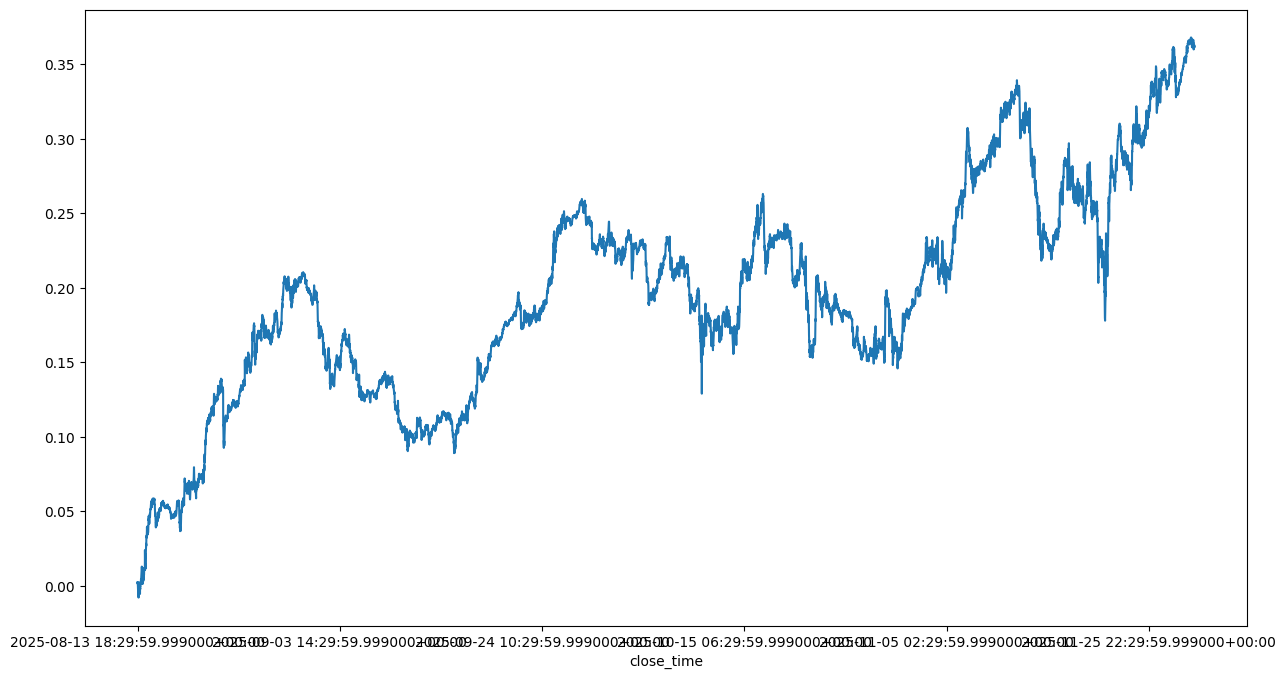

In [371]:
df_test["cum_trade_log_return"].plot(figsize=(15,8));

<Axes: xlabel='close_time'>

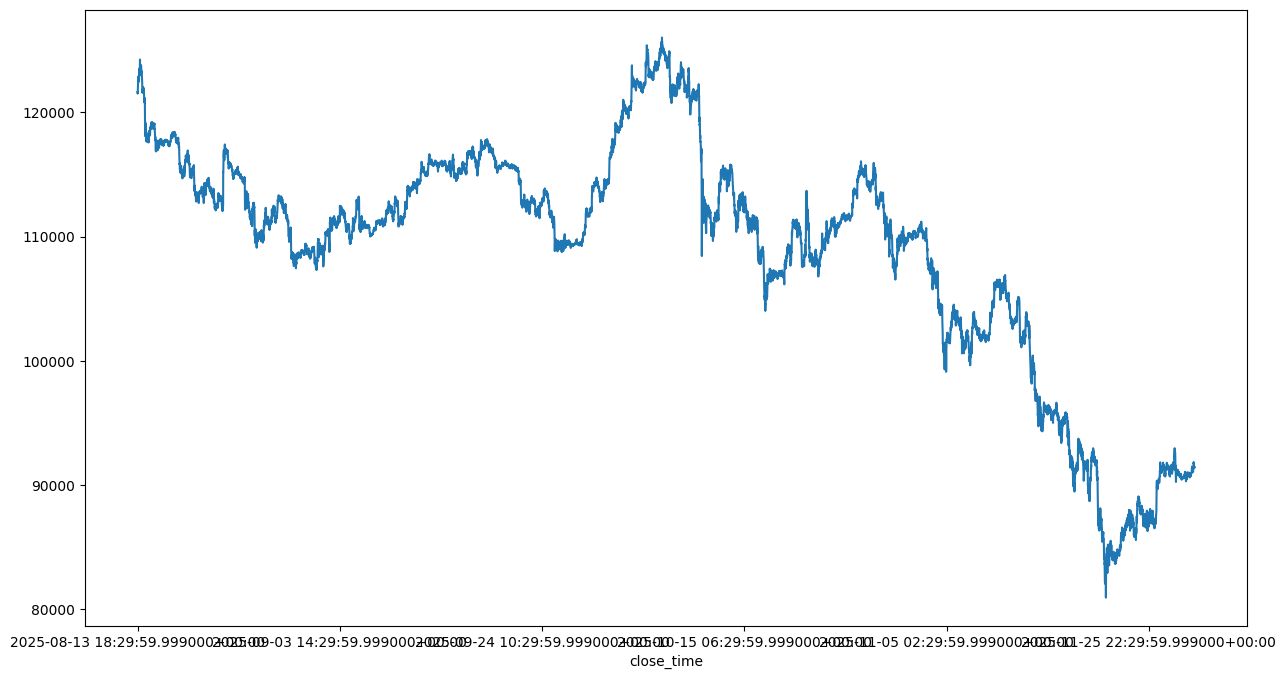

In [372]:
df_test["close"].plot(figsize=(15,8))

#### Display equity curve

In [373]:
intial_capital = 100

<Axes: xlabel='close_time'>

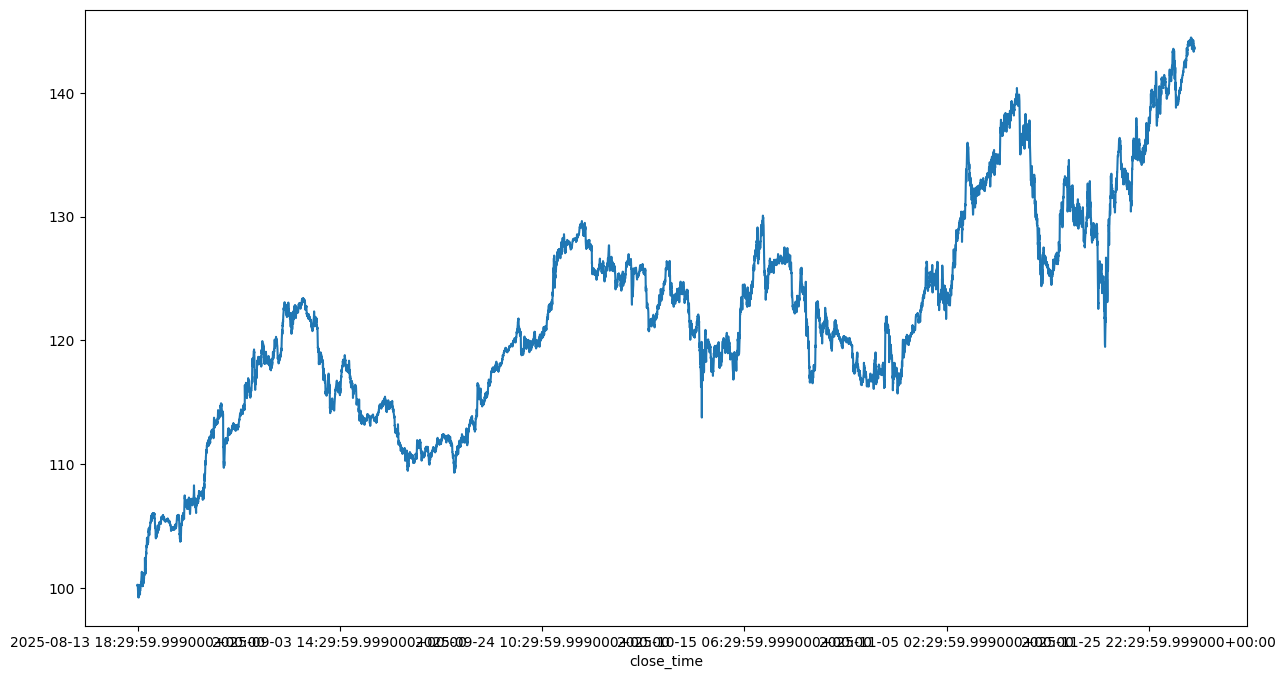

In [374]:
df_test["trade_gross_pnl"] = np.exp(df_test["cum_trade_log_return"]) *intial_capital
df_test["trade_gross_pnl"].plot(figsize=(15,8))